In [1]:
import cv2
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from skimage import color
!pip install mediapipe
import mediapipe as mp
from google.colab.patches import cv2_imshow
import tensorflow as tf

Mounted at /content/drive
     |████████████████████████████████| 32.7 MB 1.6 MB/s 


In [2]:
def rescale(image, width, height):
  new_im = cv2.resize(image,(width,height))
  # rescale to be from -1 to 1
  # new_im = (new_im - 127.5) / 127.5
  return new_im

#CMYK to RGB
def convert(image):
  new_image = np.zeros((image.shape[0],image.shape[1],image.shape[2]-1))
  print(new_image.shape)
  new_image[:,:,0] = 255*(1-image[:,:,0]/100)*(1-image[:,:,3]/100)
  new_image[:,:,1] = 255*(1-image[:,:,1]/100)*(1-image[:,:,3]/100)
  new_image[:,:,2] = 255*(1-image[:,:,2]/100)*(1-image[:,:,3]/100)
  return new_image

def filter(image):
  # convert to gray
  gray = color.rgb2gray(image)
  gray = gray.astype('uint8')

  # threshold input image as mask and negate mask
  edges = cv2.Canny(gray,255,200)
  edges = 255 - edges

  # gradient
  blur = cv2.GaussianBlur(gray,(3,3),3)
  gradient = cv2.Laplacian(blur,5,0)
  gradient = gradient/gradient.max()

  return(edges, gradient)

In [3]:


# FOR INITIAL RAW IMAGES
faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/def_front/'
ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/ok_front/'

# FOR AUGMENTED IMAGES
#faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/'
#ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/'
directories = (faulty_dir, ok_dir)

# check the total number of images we have
faulty = 0
ok = 0
j = -1
for direct in directories:
  j += 1
  for file in os.listdir(direct):
    # count only number of faulty images
    if j == 0:
      faulty += 1
    if j == 1:
      ok += 1

input_shape = (100, 100, 3)
height = input_shape[0]
width = input_shape[1]
channels = input_shape[2]

X_ok = np.zeros((ok,height,width,channels))
X_faulty = np.zeros((faulty,height,width,channels))
y_tot = np.zeros((faulty+ok))

# populate the array with only faulty images
i = 0
k = 0
j = -1
for direct in directories:
  j+=1
  if j == 0:
    for file in os.listdir(direct):
      path = (direct+file)
      im = cv2.imread(path)
      scaled_im = rescale(im, width, height)
      #edges, gradient = filter(scaled_im)
      X_faulty[i,:,:,:] = scaled_im
      y_tot[i] = 1
      i += 1
  else:
    for file in os.listdir(direct):
      path = (direct+file)
      im = cv2.imread(path)
      scaled_im = rescale(im, width, height)
      #edges, gradient = filter(scaled_im)
      X_ok[k,:,:,:] = scaled_im
      y_tot[i] = 0
      k += 1

In [4]:
print(X_ok.shape, X_faulty.shape)

(519, 100, 100, 3) (781, 100, 100, 3)


In [16]:
edge = []
grad = []
for i in range(4):
  edges, gradient = filter(X_faulty[i,:,:,:])
  edge.append(edges)
  grad.append(gradient)
  
edge = np.array(edge)
grad = np.array(grad)
print(edge.shape)

(4, 100, 100)


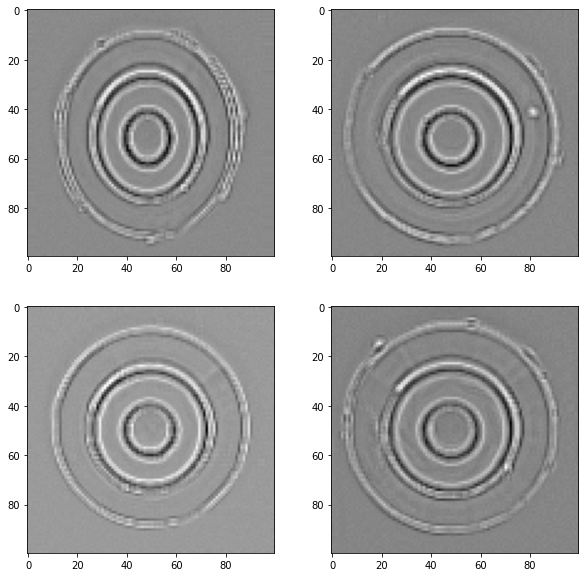

In [20]:
f, axarr = plt.subplots(2,2,figsize=(10,10))
for i in range(4):
  row = int(i/2)
  col = int(i%2)
  axarr[row,col].imshow(grad[i,:,:], cmap='gray')
plt.show()

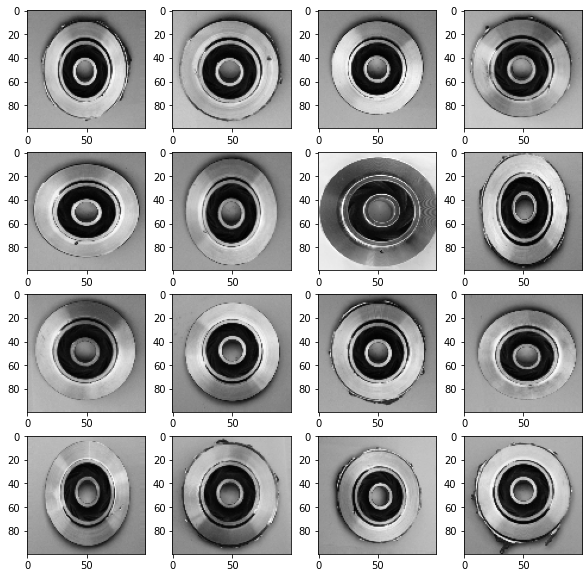

In [6]:
f, axarr = plt.subplots(4,4,figsize=(10,10))
for i in range(16):
  row = int(i/4)
  col = int(i%4)
  axarr[row,col].imshow(X_faulty[i,:,:,0], cmap='gray')
plt.show()

In [7]:
def mask(image):
  # convert to gray
  img = image.astype('uint8')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # threshold input image as mask
  mask = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)[1]

  # negate mask
  mask = 255 - mask

  # apply morphology to remove isolated extraneous noise
  # use borderconstant of black since foreground touches the edges
  kernel = np.ones((3,3), np.uint8)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

  # anti-alias the mask -- blur then stretch
  # blur alpha channel
  mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

  # linear stretch so that 127.5 goes to 0, but 255 stays 255
  mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

  # put mask into alpha channel
  result = img.copy()
  result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
  result[:, :, 3] = mask

  # display result, though it won't show transparency
  cv2_imshow(img)
  cv2_imshow(gray)
  cv2_imshow(mask)
  cv2_imshow(result)

In [8]:
def get_circle(img, minR, maxR, p1, p2):
  circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,1,img.shape[0]/8, param1=p1,param2=p2,minRadius=minR,maxRadius=maxR)
  circles = np.uint16(np.around(circles))
  #return circles
  return circles[0,:]

def Hough(image):
  gray = image.astype('uint8')
  gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
  circle_final = np.ones(3)
  circle_iter = np.zeros(3)
  for j in [3,5]:
    gray = cv2.medianBlur(gray, j)
    if circle_iter[2] > circle_final[2]:
      circle_final = circle_iter
    for i in [40,50,60,70]:
      circles = get_circle(gray, 10, 400, i, 30)
      index_radius = np.argmax(circles[:,2])
      circle_iter = circles[index_radius,:]
      #index_x_center = np.argmin(np.abs(circles[:,0]-40))
      #index_y_center = np.argmin(np.abs(circles[:,1]-40))
      #circle_iter[0] = circles[index_x_center,:][0]
      #circle_iter[1] = circles[index_y_center,:][1]
      #circle_iter[2] = circles[index_radius,:][2]
      if circle_iter[2] > circle_final[2]:
        circle_final = circle_iter

  center = (int(circle_final[1]),int(circle_final[2]))
  radius = int(circle_final[2])
  cv2.circle(gray, center, 1, (0, 0, 0), 3)
  cv2.circle(gray, center, radius, (255, 255, 255), 3)
  cv2_imshow(gray)
  return [center, radius]

In [9]:
def Hough(image):
    gray = image.astype('uint8')
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT,1,gray.shape[0]/8, param1=50,param2=30,minRadius=20,maxRadius=40)
    circles = np.uint16(np.around(circles))[0,:]
    for i in range(len(circles)):
      center = (int(circles[i,0]),int(circles[i,1]))
      radius = circles[i,2]
      cv2.circle(gray, center, 1, (0, 0, 0), 3)
      cv2.circle(gray, center, radius, (255, 255, 255), 3)
      cv2_imshow(gray)
    return circles

In [10]:
#Use k-means clustering
def run_kmeans(K, niter, image):
    
    # Load and transform an image
    img = image.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, nchannel = img.shape
    #scale = 500/max(height, width) # The longer side will be resized to 500
    #img = cv2.resize(img, (int(width*scale), int(height*scale)))

    # Vectorize the image
    x = img.reshape((-1, 3)).astype(np.float32)

    # Run K-means clustering
    labels, centroids = kmeans(x, K, niter)
    
    # Produce the resulting image segmentation. 
    centroids = np.uint8(centroids)
    labels = np.int8(labels)
    result = centroids[labels.flatten()]
    result_image = result.reshape((img.shape))

    # Visualize the original image and the segmentation.
    plt.figure(figsize=(5, 5))
    plt.subplot(1,2,1)
    plt.imshow(img); plt.title('Original Image'); plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(result_image); plt.title('Segmented Image (K={})'.format(K)); plt.axis('off')
    plt.show()

def kmeans(x, K, niter, seed=123):

    np.random.seed(seed)
    idx = np.random.choice(len(x), K, replace=False)

    # Randomly choose centroids
    centroids = x[idx, :]

    # Initialize labels
    labels = np.zeros((x.shape[0], ))
    changed = True
    i = 0
    
    while changed:
        
        if i == niter - 1:
            changed = False
            
        X_norms = np.array([np.sum(np.square(x),axis=1)])
        # Square of the matrix elements and summing across the rows
        centroids_norms = np.array([np.sum(np.square(centroids),axis=1)])
        # Finding xi*wj by doing X*WT
        X_dot_centroids = 2*np.matmul(x,np.transpose(centroids))

        distances = np.transpose(X_norms) + centroids_norms - X_dot_centroids
        temp = np.argmin(distances, axis = 1)
        
        if np.array_equal(temp, labels):
            changed = False 
        
        labels = temp
        centroid_labels, centroid_counts = np.unique(labels, return_counts=True)
        indx = np.isin(np.arange(K), centroid_labels)
        # number of times each centroid is associated with a point
        counts = np.zeros(K)
        # The index of the count matrix corresponds to the number of times the entry appears in u2
        counts[indx] = centroid_counts[indx]
        # adding 1e-20 to avoid division by 0 in final line
        counts = counts.reshape(K, 1) + 1e-20 
        # vectorized way of calculating sum over rows associated with each cluster
        sums = (np.eye(K)[labels]).T @ x
        centroids = sums/counts
        
        i+=1
    
    return labels, centroids

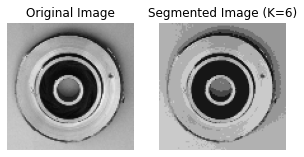

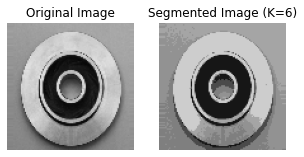

In [29]:
run_kmeans(6, 20, X_faulty[1,:,:,:])
run_kmeans(6, 20, X_ok[1,:,:,:])

In [ ]:
import tensorflow as tf
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet50(include_top = False, weights='imagenet', pooling='avg',))
MyModel.layers[0].trainable = False

In [ ]:
from sklearn.model_selection import train_test_split
X_tot = np.concatenate((X_faulty, X_ok))
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X_tot, y_tot, test_size = 0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state=1)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape)
img = tf.keras.applications.resnet50.preprocess_input(X_train)
extractedFeatures = MyModel.predict(img)

(910, 200, 200, 3) (195, 200, 200, 3) (195, 200, 200, 3)
(910,)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
data = AgglomerativeClustering(n_clusters = 3, compute_distances=True).fit(extractedFeatures)

In [ ]:
print(1-np.sum(y_train-data.labels_)/len(X_train))

0.721978021978022


In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
dimReducedDataFrame = pd.DataFrame(extractedFeatures)
dimReducedDataFrame = dimReducedDataFrame.rename(columns = { 5: 'V1', 1 : 'V2'})
plt.figure(figsize = (10, 5))
sb.scatterplot(data = dimReducedDataFrame, x = 'V1', y = 'V2')
plt.grid(True)
plt.show()

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


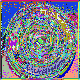

0 / 10000 : 1522 8.634389877319336


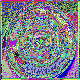

In [ ]:
#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

image = X_ok[0,:,:,:]
use_cuda = torch.cuda.is_available()
M = 2
LR = 0.0005
minL = 2
N = 80*80
T = 1000
C = 5
visualize = True

# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim, N, M):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, N, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(N)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(M-1):
            self.conv2.append( nn.Conv2d(N, N, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(N) )
        self.conv3 = nn.Conv2d(N, N, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(N)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(M-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# load image
im = image.astype('uint8')
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# slic
labels = segmentation.slic(im, compactness=C, n_segments=5)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

# train
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))

for batch_idx in range(1000):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1,  N )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if visualize:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        cv2_imshow(im_target_rgb )
        cv2.waitKey(10)

    # superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', 10000, ':', nLabels, loss.item())

    if nLabels <= minL:
        print ("nLabels", nLabels, "reached minLabels", minL, ".")
        break

# save output image
if not visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, N )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )

cv2.imwrite( "output.png", im_target_rgb )